#Uber Surge Pricing

Authors: Peter Traber, Dillon Tiner, Abigail Orlando, Summer Carter

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('dillontiner', 'cgk2wkqmms')

##Overview and Motivation

Uber is a mobile application that provides nearby car-service for users. Through the application, a user can request a car at a specific location and the user is notified how long it will take for the car to arrive. The standard fare is based on time and distance traveled. If the demand for car-service exceeds the supply of available cars, then uber applies a surge price to the fare. The surge can be anywhere from 1.1 - 50.0 times the standard fare.


We wanted to explore uber’s concept of surge pricing by conducting an analysis of which factors affect surge pricing the most. This was particularly interesting to us because uber’s API was just recently made public, so there have not been many predictive/analytical projects looking at surge pricing. This gives us a novel opportunity to explore data that affects our daily lives, and to incorporate several of the statistics and computational methodologies that we learned this semester. The data set that we have compiled can also allow us to look at many different variables and their effect on surge pricing. For example, we will look at how temperature and weather affect the surge charge on an uber. Also, should someone call the Uber now, or if they have time wait an hour or two in order to try and find a better price? We all use uber, and love the service; however, we wanted to create a predictive model in order to find the times that we do not have to be charged extra money!

## Related Work

Lecture 6: Storytelling 

We read this research paper from the University of Chicago on surge pricings.
http://faculty.chicagobooth.edu/chris.nosko/research/effects_of_uber's_surge_pricing.pdf

We read this article at the beginning of our project to get an idea of how Uber surge works.
https://www.washingtonpost.com/news/wonk/wp/2015/04/17/how-uber-surge-pricing-really-works/



##Initial Questions

Initially the main question we were trying to answer was “Can we predict what uber’s surge pricing is going to be based on an input of relevant conditions?”. As we started to accumulate and explore the data through cleanup we narrowed down the relevant conditions for our analysis to be time, weather conditions, temperature, income, and location.  

We used Amazon Web Services DynamoDB to make requests to Uber’s API as well as a weather underground API every 5 minutes with the following code:



In [2]:

# import csv
# import datetime
# import hashlib
# import logging
# import requests
# import time

# from boto.dynamodb2.table import Table
# from boto import s3

# logging.basicConfig(filename='{:%Y%m%d%H%M}.log'.format(datetime.datetime.now()),
#                     format='%(asctime)s %(message)s',
#                     level=logging.WARN)
# w_url = 'http://api.wunderground.com/api/<your wunderground token here>/conditions/q/{lat},{lon}.json'
# u_db = Table('uber')
# u_url = 'https://api.uber.com/v1/estimates/price'
# u_server_token = <your uber token here>

# coordinates = [line for line in csv.DictReader(open('coordinates.csv', 'r'))]

# # Start an infinite loop.
# while True:
    
#     for coord in coordinates:
#         # Make weather request.
#         response = requests.get(w_url.format(**coord))
        
#         # Log and continue to next iteration if the request is not successful.
#         if response.status_code != requests.codes.ok:
#             logging.error('Unable to get weather data for {lat}, {lon}'.format(**coord))
#             continue
            
#         weather = response.json()
        
#         # Prepare Uber request.
#         params = {
#             'server_token': u_server_token,
#             'start_latitude': coord['lat'],
#             'start_longitude': coord['lon'],
#             'end_latitude': coord['lat'],
#             'end_longitude': coord['lon'],
#         }
        
#         # Make Uber request.
#         response = requests.get(u_url, params=params)
        
#         # Log and continue to next iteration if the request is not successful.
#         if response.status_code != requests.codes.ok:
#             logging.error('Unable to get Uber data for {lat}, {lon}'.format(**coord))
#             continue        
        
#         data = response.json()
        
#         # Save response time to use as timestamp.
#         resp_time = response.headers.get('Date')
        
#         for product in data['prices']:
            
#             logging.warn('Adding {} in {} to database.'.format(
#                 product['display_name'],
#                 weather['current_observation']['display_location']['state']
#             ))
            
#             u_db.put_item(data={
#                 # Hash fields to create unique keys.
#                 '_id': hashlib.md5(
#                     (product['display_name'] +
#                      weather['current_observation']['display_location']['full'] +
#                      coord['income'] +
#                      resp_time).encode()
#                     ).hexdigest(),
#                 'income': coord['income'],
#                 'time': resp_time,
#                 'product': product['display_name'],
#                 'surge': product['surge_multiplier'],
#                 'city': weather['current_observation']['display_location']['city'],
#                 'state': weather['current_observation']['display_location']['state'],
#                 'weather': weather['current_observation']['weather'],
#                 'temp': round(weather['current_observation']['temp_f']) 
                
#             })

#     # Sleep for 5 minutes (300 seconds).
#     time.sleep(300)


##Cleaning the Data

In [3]:
#Importing the data to ipython notebook
uber_data = pd.read_csv('output3.csv')
df=pd.read_csv("output3.csv")
# Convert the Surge to decimal values
uber_data['surge'] = uber_data['surge']/10.0
uber_data.head()

,time,city,income,state,product,_id,temp,surge,weather
0,"Fri, 20 Nov 2015 22:19:52 GMT",Atlanta,High,GA,UberSUV,b605b0b06730c256bc90499b6c53afaf,62,1,Clear
1,"Sat, 28 Nov 2015 13:39:55 GMT",San Francisco,Low,CA,UberSUV,5ac25b0bb4283ddcd818a07d5e7507d5,47,1,Clear
2,"Thu, 03 Dec 2015 12:26:05 GMT",Washington,Middle,DC,UberBLACK,8c973b036ce2d06c5b26f789a0f5fab5,40,1,Clear
3,"Mon, 30 Nov 2015 03:16:49 GMT",Atlanta,Low,GA,uberXL,a209e7632350d72f82aff073fc406563,69,1,Overcast
4,"Wed, 18 Nov 2015 17:54:37 GMT",Atlanta,Low,GA,UberBLACK,06acbfc4f40ff6cb6ef15a8755945079,66,1,Rain


In [4]:
uber_data.describe()

,temp,surge
count,282398.000000,282398.000000
mean,49.619179,1.024198
std,8.314591,0.146514
min,21.000000,1.000000
25%,44.000000,1.000000
50%,49.000000,1.000000
75%,55.000000,1.000000
max,76.000000,4.900000


In [5]:
uber_surge_mean = uber_data['surge'].mean()
uber_surge_mean

1.024198117550413

In [6]:
# Function to put full name of Day
def day_fix(string):
    if string == 'Mon':
        return "Monday"
    elif string =='Tue':
        return "Tuesday"
    elif string =='Wed':
        return "Wednesday"
    elif string =='Thu':
        return 'Thursday'
    elif string == 'Fri':
        return 'Friday'
    elif string == 'Sat':
        return 'Saturday'
    elif string == 'Sun':
        return 'Sunday'
    else:
        print "Error in day_fix!!!!!"
        
# Function to round everything **Down** to the nearest 10 minutes
def min_fix(string):
    num = int(string)
    return str(num - (num%10))

# Check and replace the surge
def surge_check(surge):
    surge = surge * 10
    if surge == 10:
        return "No Surge"
    elif surge > 15:
        return "High Surge"
    elif surge == 15:
        return "Mid Surge"
    else:
        return "Low Surge"

In [7]:
# Code to test No Surge vs Low Surge vs. High Surge

count_nosurge = df['surge'] == 10
count_surge = df['surge'] != 10
surgedf = df[count_surge]

count_highsurge = df['surge'] > 15
count_lowsurge = surgedf['surge'] < 15
count_midsurge = surgedf['surge'] == 15

print 'Percentage of data that has surge %0.3f' % (float(sum(count_surge))/len(df))
print 'Percentage of Surge that has Low Surge %0.3f' % (float(sum(count_lowsurge))/sum(count_surge))
print 'Percentage of Surge that has High Surge %0.3f' % ((float(sum(count_highsurge))/sum(count_surge)))
print 'Percentage of Surge that has Mid Surge %0.3f' % (float(sum(count_midsurge))/sum(count_surge))

Percentage of data that has surge 0.038
Percentage of Surge that has Low Surge 0.333
Percentage of Surge that has High Surge 0.342
Percentage of Surge that has Mid Surge 0.325


After messing with the data, found that only a small percentage of the data has a Surge (only 3.8%). After digging deeper into the surge prices and messing around with different combinations I set the limits at **Low Surge < 1.5x**, **Mid Surge = 1.5x**, and **High Surge > 1.5x**. I thought that is a fair cut off as well because you are spending 50% more on the ride at 1.5x surge.

The first function is just to correct the days from their shortened version into full length versions (e.g. "Mon" -> "Monday")

In [8]:
#Code to clean cartype
for index in uber_data.index:
    if uber_data.loc[index,'product'] == 'uberX + Car Seat':
        uber_data.loc[index,'product'] = 'uberX'
    elif uber_data.loc[index,'product'] == 'SUV + Car Seat':
        uber_data.loc[index,'product'] = 'UberSUV'
    elif uber_data.loc[index,'product'] == 'BLACK CAR + Car Seat':
        uber_data.loc[index,'product'] = 'UberBlack'
    elif uber_data.loc[index,'product'] == 'UberSELECT':
        uber_data.loc[index,'product'] = 'uberSELECT'
    elif uber_data.loc[index,'product'] == 'uberT':
        uber_data.loc[index,'product'] = 'uberTAXI'
    elif uber_data.loc[index,'product'] == 'UberBLACK':
        uber_data.loc[index,'product'] = 'UberBlack'

In [9]:
# Cleaning the Weather Column
for row in range(len(uber_data)):
    if uber_data.loc[row,'weather'] == 'Light Rain':
        uber_data.loc[row,'weather'] = 'Rain'
    elif uber_data.loc[row,'weather'] == 'Scattered Clouds':
        uber_data.loc[row,'weather'] = 'Cloudy'
    elif uber_data.loc[row,'weather'] == 'Mostly Cloudy':
        uber_data.loc[row,'weather'] = 'Cloudy'
    elif uber_data.loc[row,'weather'] == 'Partly Cloudy':
        uber_data.loc[row,'weather'] = 'Cloudy'
    elif uber_data.loc[row,'weather'] == 'Overcast':
        uber_data.loc[row,'weather'] = 'Clear'

In [10]:
# Remove the extra rows from the dataframe
remove = ['uberWAV', 'WAV', 'uberFAMILY', 'ASSIST', 'Yellow WAV', '(RED)']
remove_mask = [i not in remove for i in uber_data['product']]
uber_data =uber_data[remove_mask]
uber_data.reset_index(inplace=True, drop = True)

In [11]:
# Code to extract Weekdays and time of day from given dataframe
time_list = [uber_data.time[index].split(' ') for index in uber_data.index]
weekday_list = []
hour_list = []
for row in range(len(time_list)):
    
    #Cleaning the time column from the queried data set
    time_list[row].remove('GMT')
    time_list[row][0] = time_list[row][0].replace(',','')
    time_list[row][0] = day_fix(time_list[row][0])
    hour = int(time_list[row][4][0:2])
    
    # fix the time change
    if uber_data.loc[row,'city'] == 'San Francisco':
        hour = hour - 8
    else: 
        hour = hour - 5
    if hour < 0 :
        hour = 24 + hour
    
    # Append the Weekday to a list to be put into the dataframe
    weekday_list.append(time_list[row][0])
    
    # call the min_fix function above and create the hours in 10 minute intervals
    hour_list.append( str(hour) + ':' + min_fix(time_list[row][4][3:5]) )

In [12]:
#Code to convert Temp to ints
temperature_list = [int(uber_data.temp[index]) for index in uber_data.index]

In [13]:
surge_list = [surge_check(uber_data.surge[index]) for index in uber_data.index]

In [14]:
# Create Final Dataframe for exploratory analysis
dict_final = {}
dict_final = {'id': uber_data._id , 'surge':uber_data['surge'], 'temperature': temperature_list, 'weather': uber_data.weather,
             'cartype': uber_data['product'], 'city': uber_data.city, 'income': uber_data.income, 'weekday': weekday_list, 
              'time': hour_list}
df_finale = pd.DataFrame(dict_final)
df_finale.reset_index(inplace=True, drop = True)
df_finale.head()

# Create Final Dataframe for Model Building
dict_final = {}
dict_final = {'id': uber_data._id , 'surge':surge_list, 'temperature': temperature_list, 'weather': uber_data.weather,
             'cartype': uber_data['product'], 'city': uber_data.city, 'income': uber_data.income, 'weekday': weekday_list, 
              'time': hour_list}
df_final = pd.DataFrame(dict_final)
df_final.reset_index(inplace=True, drop = True)
df_final.head()

,cartype,city,id,income,surge,temperature,time,weather,weekday
0,UberSUV,Atlanta,b605b0b06730c256bc90499b6c53afaf,High,No Surge,62,17:10,Clear,Friday
1,UberSUV,San Francisco,5ac25b0bb4283ddcd818a07d5e7507d5,Low,No Surge,47,5:30,Clear,Saturday
2,UberBlack,Washington,8c973b036ce2d06c5b26f789a0f5fab5,Middle,No Surge,40,7:20,Clear,Thursday
3,uberXL,Atlanta,a209e7632350d72f82aff073fc406563,Low,No Surge,69,22:10,Clear,Monday
4,UberBlack,Atlanta,06acbfc4f40ff6cb6ef15a8755945079,Low,No Surge,66,12:50,Rain,Wednesday


## Exploratory Data Analysis

###Day of Week's Effect on Surge

In [101]:
# Group by day of the week
weekday_mean = df_finale.groupby('weekday').mean().reset_index()
weekday_mean['count'] = df_finale.groupby('weekday').surge.count().tolist()
weekday_mean = weekday_mean.sort(['surge'], ascending = False)
weekday_mean

,weekday,surge,temperature,count
4,Thursday,1.027199,50.394940,50157
5,Tuesday,1.025331,48.440430,34321
0,Friday,1.025260,50.810765,40669
6,Wednesday,1.022903,49.511193,61869
1,Monday,1.019212,45.580509,24339
2,Saturday,1.016350,53.140547,17688
3,Sunday,1.009939,48.357962,18583


In [102]:
weekday_mean_dict = dict(zip(weekday_mean.weekday, weekday_mean.surge))
weekday_mean_dict

{'Friday': 1.0252600260640792,
 'Monday': 1.0192119643370736,
 'Saturday': 1.0163500678426041,
 'Sunday': 1.0099391917343818,
 'Thursday': 1.0271985964072832,
 'Tuesday': 1.0253314297368976,
 'Wednesday': 1.0229032310203825}

In [103]:
a = [uber_surge_mean]*7

trace = go.Scatter(
    x=weekday_mean['weekday'],
    y=weekday_mean['surge'],
    mode = 'markers',
    marker=dict(
        symbol='circle',
        size=weekday_mean['count']*.0005,
    ),
    name = 'Week Day Surge Mean'
)

trace1 = go.Scatter(
    x=weekday_mean['weekday'],
    y=a,
    mode = 'lines',
    name = 'Overall Surge Mean')

data = [trace, trace1]
layout = go.Layout(
    title='Effect of Week Day on Surge',
    xaxis=dict(title='Week Day'),
    yaxis=dict(title='Surge'))


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Weekday_on_surge')

The radius of the points reflects the count of data per day of the week. Thursday's surge of ~1.027 and Friday's surge of ~1.025 are slightly above the average surge of ~1.024. This is could be explained by the fact that Thursday and Friday are the beginning of the weekend and people are going out at night more and/or traveling. Saturday's surge of ~1.016 and Sunday's surge of ~1.001 are more below average than Thursday and Friday are above average possibly due to the fact that people are using other modes of transportation on the weekends or the fact that there are more uber drivers available because many drivers are part-time drivers.

###Weather's effect on surge:

In [104]:
weather_mean = uber_data.groupby('weather').mean().reset_index()
weather_mean['count'] = uber_data.groupby('weather').surge.count().tolist()
weather_mean = weather_mean.sort(['surge'], ascending = False)
weather_mean

,weather,temp,surge,count
3,Rain,49.433927,1.026414,19766
1,Cloudy,49.987423,1.023480,77999
0,Clear,49.365861,1.021931,145823
2,Fog,47.802377,1.016790,4038


In [105]:
weather_mean_dict = dict(zip(weather_mean.weather, weather_mean.surge))
weather_mean_dict

{'Clear': 1.0219313825665315,
 'Cloudy': 1.0234797882024103,
 'Fog': 1.0167904903417531,
 'Rain': 1.0264140443185275}

In [106]:
weather_helper = []
for i in (weather_mean['count']):
    x = np.sqrt(i)
    weather_helper.append(x)
    

weather_sqrt_count = pd.DataFrame(weather_helper, columns =['sqrt_count'] )

In [107]:
a = [uber_surge_mean]*7

trace = go.Scatter(
    x=weather_mean['weather'],
    y=weather_mean['surge'],
    mode = 'markers',
    marker=dict(
        symbol='circle',
        size=(weather_sqrt_count['sqrt_count'])*.2,
    ),
    name = 'Weather Type Surge Mean'
)

trace1 = go.Scatter(
    x=weather_mean['weather'],
    y=a,
    mode = 'lines',
    name = 'Overall Surge Mean')

data = [trace, trace1]
layout = go.Layout(
    title='Effect of Weather on Surge',
    xaxis=dict(title='Weather'),
    yaxis=dict(title='Surge'))


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Weather_on_surge')

The radius of the points reflects the count of data points per weather condition. We applied a square root transformation to the counts to help with the visualization. From the radius of the points we can tell that very few data points had foggy and rainy weather. Most of the weather from the past few weeks was clear. Rain has the highest surge value of ~1.026 which is slightly above the average surge value of ~1.024. This is not surprising because when it rains more people will be requesting Ubers to get out of the weather. Cloudy, clear, and fog have below average surge values.

###Temperature's effect on surge

In [108]:
temp_mean = uber_data.groupby('temp').mean().reset_index()
temp_mean['count'] = uber_data.groupby('temp').surge.count().tolist()
temp_mean = temp_mean.sort(['surge'], ascending = False)
temp_mean.head()
temp_mean_dict = dict(zip(temp_mean.temp, temp_mean.surge))

In [109]:
temp_helper = []
for i in (temp_mean['count']):
    x = np.sqrt(i)
    temp_helper.append(x)

In [110]:
temp_sqrt_count = pd.DataFrame(temp_helper, columns =['sqrt_count'] )

In [111]:
a = [uber_surge_mean]*7

trace = go.Scatter(
    x=temp_mean['temp'],
    y=temp_mean['surge'],
    mode = 'markers',
    marker=dict(
        symbol='circle',
        size=temp_sqrt_count['sqrt_count']*(.2))
)

trace1 = go.Scatter(
    x=temp_mean['temp'],
    y=a,
    mode = 'lines',
    name = 'Overall Surge Mean')

data = [trace]
layout = go.Layout(
    title='Effect of Temperature on Surge',
    xaxis=dict(title='Temperature'),
    yaxis=dict(title='Mean Surge'))


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Temp_on_surge')

The radius of the points reflects the count of data points per temperature condition. We applied a square root transformation to the counts to help with the visualization. There are fewer data points from the coldest and warmest temperatures. The surge price appears to rise for the coldest (25-40 degrees) and warmest (73-76 degrees) temperatures. This is probably because users are less likely to walk, bike or skateboard outdoors when it is really cold or really hot.

###Car Type's effect on surge

In [112]:
car_mean = uber_data.groupby('product').mean().reset_index()
car_mean = car_mean.drop('temp', 1).sort(['surge'], ascending = False) 
car_mean['count'] = uber_data.groupby('product').surge.count().tolist()
car_mean_dict = car_mean.set_index('product').surge.to_dict()
car_mean

,product,surge,count
4,uberX,1.061015,51238
5,uberXL,1.023235,51237
2,uberSELECT,1.015537,17062
1,UberSUV,1.013455,34162
0,UberBlack,1.010672,51237
3,uberTAXI,1.000000,42690


In [113]:
product_helper = []
for i in (car_mean['count']):
    x = np.sqrt(i)
    product_helper.append(x)
product_sqrt_count = pd.DataFrame(product_helper, columns =['sqrt_count'] ) 

In [114]:
a = [uber_surge_mean]*7

trace = go.Scatter(
    x=car_mean['product'],
    y=car_mean['surge'],
    mode = 'markers',
    marker=dict(
        symbol='circle',
        size=product_sqrt_count['sqrt_count']*(.2))
)


trace1 = go.Scatter(
    x=car_mean['product'],
    y=a,
    mode = 'lines',
    name = 'Overall Surge Mean')

data = [trace]
layout = go.Layout(
    title='Effect of Car Type on Surge',
    xaxis=dict(title='Car Type'),
    yaxis=dict(title='Mean Surge'))


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Car_on_surge')



The radius of the points reflects the count of data points per car type. We applied a square root transformation to the counts to help with the visualization. UberX has the highest mean surge. It makes sense that UberX has the highest surge, because it is the most in demand due to its cheap flat rate. UberTaxi has the lowest mean surge, 1.0. It is likely that this car type doesn't have surge functionality.

###Socioeconomic effect on surge

In [115]:
income_mean = uber_data.groupby('income').mean().reset_index()
income_mean = income_mean.drop('temp', 1).sort(['surge'], ascending = False) 
income_mean['count'] = uber_data.groupby('income').surge.count().tolist()
income_mean_dict = income_mean.set_index('income').surge.to_dict()
income_mean



,income,surge,count
0,High,1.027200,82541
2,Middle,1.021941,82545
1,Low,1.018939,82540


In [116]:
income_helper = []
for i in (income_mean['count']):
    x = np.sqrt(i)
    income_helper.append(x)
income_sqrt_count = pd.DataFrame(income_helper, columns =['sqrt_count'] ) 

In [117]:
a = [uber_surge_mean]*7

trace = go.Scatter(
    x=income_mean['income'],
    y=income_mean['surge'],
    mode = 'markers',
    marker=dict(
        symbol='circle',
        size=income_sqrt_count['sqrt_count']*(.2))
)

trace1 = go.Scatter(
    x=income_mean['income'],
    y=a,
    mode = 'lines',
    name = 'Overall Surge Mean')

data = [trace]
layout = go.Layout(
    title='Effect of Income on Surge',
    xaxis=dict(title='Income'),
    yaxis=dict(title='Mean Surge'))


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Income_on_surge')




The radius of the points reflects the count of data points per income condition. We applied a square root transformation to the counts to help with the visualization. Since the size of the radii appear to be about the same size, we know that there are about the same amount of Uber rides in each neighborhood. High Income neighborhoods have the highest mean surge, followed by middle income and lastly low income. This is likely due to the tendency of users to live in high income areas. Uber is a luxury service, especially in big cities where public transportation is available. Also it requires the use of a smartphone, which high income users are more likely to own. Since there is more demand in high-income neighborhoods, then there is a higher average surge.

###City's effect on surge

In [118]:
city_mean = uber_data.groupby('city').mean().reset_index()
city_mean = city_mean.drop('temp', 1).sort(['surge'], ascending = False)
city_mean['count'] = uber_data.groupby('city').surge.count().tolist()
city_mean_dict = city_mean.set_index('city').surge.to_dict()
city_mean


,city,surge,count
1,Boston,1.040150,42633
4,Washington,1.035978,42794
3,San Francisco,1.012890,42668
0,Atlanta,1.012026,51179
2,New York,1.006319,68352


In [119]:
city_helper = []
for i in (city_mean['count']):
    x = np.sqrt(i)
    city_helper.append(x)
city_sqrt_count = pd.DataFrame(city_helper, columns =['sqrt_count'] ) 

In [120]:
a = [uber_surge_mean]*7

trace = go.Scatter(
    x=city_mean['city'],
    y=city_mean['surge'],
    mode = 'markers',
    marker=dict(
        symbol='circle',
        size=city_sqrt_count['sqrt_count']*(.2))
)

trace1 = go.Scatter(
    x=city_mean['city'],
    y=a,
    mode = 'lines',
    name = 'Overall Surge Mean')

data = [trace]
layout = go.Layout(
    title='Effect of City on Surge',
    xaxis=dict(title='City'),
    yaxis=dict(title='Mean Surge'))


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='city_on_surge')





The radius of the points reflects the count of data points per city. We applied a square root transformation to the counts to help with the visualization. The radii are about the same for each city, indicating that Uber is used at the same rate in each of our chosen cities. Boston has the highest mean surge, indicating that there is a smaller driver to user ratio in Boston than in the other cities. New York likely has the smallest mean surge because there are so many drivers and so many competeing services like NYC taxis.

###Time's effect on surge

In [121]:
uber_test = uber_data.copy()
uber_test['time'] = [i.split(' ') for i in uber_test['time']]
uber_test['time'] = [i[4] for i in uber_test['time']]

#Add hour column
uber_test['hour'] = [i[:2] for i in uber_test['time']]

#Effect of Time on Surge BEFORE ADJUSTING FOR GMT
hour_mean = uber_test.groupby('hour').mean().reset_index()
hour_mean = hour_mean.drop('temp', 1).sort(['surge'], ascending = False)
hour_mean.head()

,hour,surge
23,23,1.055438
22,22,1.054511
13,13,1.045654
7,07,1.037212
5,05,1.032407


####NYC surge hour (-5 GMT)

In [122]:
nyc = uber_test[uber_test['city'] == 'New York']
nyc['hour'] = [(int(i) - 5) if int(i) > 4 else (int(i) - 5 + 24) for i in nyc['hour']]
nyc_hour_mean = nyc.groupby('hour').mean().reset_index()
nyc_hour_mean = nyc_hour_mean.drop('temp', 1).sort(['surge'], ascending = False)
nyc_hour_mean.head()

C:\Users\ptrab_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,hour,surge
17,17,1.019583
4,4,1.016241
18,18,1.013722
5,5,1.010547
6,6,1.010515


In [123]:
trace = go.Scatter(
    x = (nyc_hour_mean['hour']),
    y = (nyc_hour_mean['surge']),
    mode = 'markers')

data = [trace]

layout = go.Layout(
    title='NYC: Effect of Time on Surge',
    xaxis=dict(title='Time of Day'),
    yaxis=dict(title='Surge'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time-surge')


In NYC, the highest mean surge is at 5 PM followed 4 AM and then 6 PM. Since rush hour is from 5-7 PM, it makes sense that there is a surge at these times because there is a greater demand. The lowest surge is at 9 AM and 8 PM which also makes sense becasue these are the hours right after high surges. Due to the surge, more Uber drivers become active, but the the demand decreases after rush hour and there is more supply than demand.

####ATL surge hour (-5 GMT)

In [124]:
atl = uber_test[uber_test['city'] == 'Atlanta']
atl['hour'] = [(int(i) - 5) if int(i) > 4 else (int(i) - 5 + 24) for i in atl['hour']]
atl_hour_mean = atl.groupby('hour').mean().reset_index()
atl_hour_mean = atl_hour_mean.drop('temp', 1).sort(['surge'], ascending = False)
atl_hour_mean.head()

C:\Users\ptrab_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,hour,surge
18,18,1.086943
17,17,1.046714
2,2,1.020306
3,3,1.019746
6,6,1.016990


In [125]:
trace = go.Scatter(
    x = (atl_hour_mean['hour']),
    y = (atl_hour_mean['surge']),
    mode = 'markers')

data = [trace]

layout = go.Layout(
    title='ATL: Effect of Time on Surge',
    xaxis=dict(title='Time of Day'),
    yaxis=dict(title='Surge'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time-surge')

There is about no surge all day in Atlanta with the exception of 5 and 6 PM. This surge is likely due to rush hour.

####SF surge hour (-8 GMT)

In [126]:
sf = uber_test[uber_test['city'] == 'San Francisco']
sf['hour'] = [(int(i) - 5) if int(i) > 4 else (int(i) - 5 + 24) for i in sf['hour']]
sf_hour_mean = sf.groupby('hour').mean().reset_index()
sf_hour_mean = sf_hour_mean.drop('temp', 1).sort(['surge'], ascending = False)
sf_hour_mean.head()

C:\Users\ptrab_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,hour,surge
11,11,1.057127
5,5,1.029540
7,7,1.027792
10,10,1.026667
12,12,1.026055


In [127]:
trace = go.Scatter(
    x = (sf_hour_mean['hour']),
    y = (sf_hour_mean['surge']),
    mode = 'markers')

data = [trace]

layout = go.Layout(
    title='SF: Effect of Time on Surge',
    xaxis=dict(title='Time of Day'),
    yaxis=dict(title='Surge'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time-surge')

In SF, the highest mean surge is at 11 AM. The time from 5 AM to 10 AM the average surge is slightly above 1.0. After noon, there is about no surge. The best explanation for the surge in the morning is that there is a high demand for Ubers on the way to work. 

####BOS surge time (-5 GMT)

In [128]:
bos = uber_test[uber_test['city'] == 'Boston']
bos['hour'] = [(int(i) - 5) if int(i) > 4 else (int(i) - 5 + 24) for i in bos['hour']]
bos_hour_mean = bos.groupby('hour').mean().reset_index()
bos_hour_mean = bos_hour_mean.drop('temp', 1).sort(['surge'], ascending = False)
bos_hour_mean.head()

C:\Users\ptrab_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,hour,surge
17,17,1.102517
1,1,1.089659
8,8,1.086444
0,0,1.075569
16,16,1.072231


In [129]:
trace = go.Scatter(
    x = (bos_hour_mean['hour']),
    y = (bos_hour_mean['surge']),
    mode = 'markers')

data = [trace]

layout = go.Layout(
    title='BOS: Effect of Time on Surge',
    xaxis=dict(title='Time of Day'),
    yaxis=dict(title='Surge'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time-surge')

The highest average surge in Boston is at 1 AM, 8 AM, and 5 PM. The latter two are likely do to rush hour for work. The surge at 1 AM is likely because there is a high demand for transportation after midnight, because the public transportation begins to close for the night. The lowest average surge in Boston is around noon and past 8 PM-- this makes sense becasue demand for ubers is low at these points of the day.

####WASH surge time (-5 GMT)

In [130]:
wash = uber_test[uber_test['city'] == 'Washington']
wash['hour'] = [(int(i) - 5) if int(i) > 4 else (int(i) - 5 + 24) for i in wash['hour']]
wash_hour_mean = wash.groupby('hour').mean().reset_index()
wash_hour_mean = wash_hour_mean.drop('temp', 1).sort(['surge'], ascending = False)
wash_hour_mean.head()

C:\Users\ptrab_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,hour,surge
18,18,1.104301
8,8,1.092200
17,17,1.088527
2,2,1.081297
0,0,1.055158


In [131]:
trace = go.Scatter(
    x = (wash_hour_mean['hour']),
    y = (wash_hour_mean['surge']),
    mode = 'markers')

data = [trace]

layout = go.Layout(
    title='WASH: Effect of Time on Surge',
    xaxis=dict(title='Time of Day'),
    yaxis=dict(title='Surge'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time-surge')

The highest average surge in Washington is at 5 and 6 PM, and 8 AM. This is likely because of rush hour at these times. The lowest average surge is around noon and after 8 PM, which makes sense because demand for transportation at this time is low.

####Combine data from all cities --- ADJUSTED for GMT

In [135]:
concat_city_surge = pd.concat([wash_hour_mean, bos_hour_mean,atl_hour_mean, sf_hour_mean, nyc_hour_mean], axis=1)
temp = concat_city_surge[["surge", "surge", "surge", "surge", "surge" ]].mean(axis=1)
holder = []
for i in range(24):
    holder.append(i)

holder = pd.DataFrame(holder, columns=['hour'])
city_surge = pd.concat([holder, temp], axis=1)
city_surge = pd.concat([holder, temp], axis=1)
city_surge.columns = ['hour', 'surge']


In [139]:
trace = go.Scatter(
    x = (city_surge['hour']),
    y = (city_surge['surge']),
    mode = 'markers')

data = [trace]

layout = go.Layout(
    title='Effect of Time on Surge',
    xaxis=dict(title='Time of Day'),
    yaxis=dict(title='Surge'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time-surge')

Overall, the highest average surge is at 5 and 6 PM, followed by 8 AM. Since these are rush hour times, it makes sense that there would be high demand for Ubers at these times, and not enough supply. The lowest average surge occurs at 10 AM and 8 PM, which also makes sense because there is generally a low demand for transportation at these times of the day.

## Statistical Model Analysis

### Model Description and Reasons

In order to predict attempt to predict surge pricing, we tested two models to be used. In this case, the dependent variable is presented in classes. We thought that classifying the surge pricing into ‘No Surge,’ ‘Low Surge,’ ‘Middle Surge,’ and ‘High Surge’ would increase the accuracy of the prediction because predicting the exact price would have been difficult with the data set. When cleaning the data set, we found an even split in the classes at 1.5x normal price. This means that any surge below 1.5x was classified as ‘Low Surge’, ‘Middle Surge’ being equal to 1.5x, and ‘High Surge’ as above 1.5x. We assumed that classifying the surge into these four categories would provide better results than predicting the actual number (e.g. classification vs. regression). The first classification model we attempted to use was a Random Forest Classifier. The second classification model we attempted to use was logistic regression with regularization. The models are implemented and described below. In the end, we used the Random Forest Classifier in our Final Analysis and application on the website. We found the accuracy to be very similiar, and the python implimentation for multi-class classification was much more stable and had better vizualization possibilietes.

###Implementation

In [15]:
# Import functions needed 
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
# split into training and test data
itrain, itest = train_test_split(xrange(df_final.shape[0]), train_size=0.7)

mask=np.ones(df_final.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)


In [17]:
#Check data cleaning
print df_final['weather'].unique()
print df_final['cartype'].unique()
print df_final['city'].unique()
print len(df_final['time'].unique())
print type(df_final['temperature'][0])

['Clear' 'Rain' 'Fog' 'Cloudy']
['UberSUV' 'UberBlack' 'uberXL' 'uberX' 'uberTAXI' 'uberSELECT']
['Atlanta' 'San Francisco' 'Washington' 'New York' 'Boston']
144
<type 'numpy.int64'>


This was only to test the data cleaning to make sure that it was cleaned well.

In [18]:
#Create the X matrix
Xvec_list = []
for i in range(len(df_final)):
    temp_dict = {}
    temp_dict['city'] = dict_final['city'][i]
    temp_dict['cartype'] = dict_final['cartype'][i]
    temp_dict['income'] = dict_final['income'][i]
    temp_dict['temperature'] = dict_final['temperature'][i]
    temp_dict['time'] = dict_final['time'][i]
    temp_dict['weather'] = dict_final['weather'][i]
    temp_dict['weekday'] = dict_final['weekday'][i]
    Xvec_list.append(temp_dict)

vec = DictVectorizer()
vec.fit_transform(Xvec_list)
fcolumns = vec.get_feature_names()
data = vec.fit_transform(Xvec_list).toarray()
X_final = pd.DataFrame(data = data, columns = fcolumns)
X_final.head()

,cartype=UberBlack,cartype=UberSUV,cartype=uberSELECT,cartype=uberTAXI,cartype=uberX,cartype=uberXL,city=Atlanta,city=Boston,city=New York,city=San Francisco,city=Washington,income=High,income=Low,income=Middle,temperature,time=0:0,time=0:10,time=0:20,time=0:30,time=0:40,time=0:50,time=10:0,time=10:10,time=10:20,time=10:30,time=10:40,time=10:50,time=11:0,time=11:10,time=11:20,time=11:30,time=11:40,time=11:50,time=12:0,time=12:10,time=12:20,time=12:30,time=12:40,time=12:50,time=13:0,time=13:10,time=13:20,time=13:30,time=13:40,time=13:50,time=14:0,time=14:10,time=14:20,time=14:30,time=14:40,...,time=3:30,time=3:40,time=3:50,time=4:0,time=4:10,time=4:20,time=4:30,time=4:40,time=4:50,time=5:0,time=5:10,time=5:20,time=5:30,time=5:40,time=5:50,time=6:0,time=6:10,time=6:20,time=6:30,time=6:40,time=6:50,time=7:0,time=7:10,time=7:20,time=7:30,time=7:40,time=7:50,time=8:0,time=8:10,time=8:20,time=8:30,time=8:40,time=8:50,time=9:0,time=9:10,time=9:20,time=9:30,time=9:40,time=9:50,weather=Clear,weather=Cloudy,weather=Fog,weather=Rain,weekday=Friday,weekday=Monday,weekday=Saturday,weekday=Sunday,weekday=Thursday,weekday=Tuesday,weekday=Wednesday
0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,1,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,1,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,1,0,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


This is just using DictVectorizer in order to create categorical dummy variables for each categorical variables. This leaves the only numerical variable 'temperature' alone. This creates the X columns to be passed into the models.

#### Random Forest

A Random Forest Classifier is an ensemble method that trains a specific number of decision trees and calculates a prediction based on running data through each tree, getting a classification, and weighing the classification by variance in order to produce a final prediction. This classifier makes sense in this context for a number of reasons. First, we are using a dataset with unbalanced classes—there are many more cases where there is ‘No Surge’ than the other three classes. As you will see later, the Random Forest accounts for the unbalanced data set using the ‘subsample’ method. This means that when each tree is being trained, the algorithm automatically samples the data to have an equal number of classes for each tree. Second, we have a lot of data. Random Forest classifiers samples from the data many times and so the prediction will be optimal if there is a lot of data to be used. Finally, we are able to look at feature importance in the data, which is particularly enlightening on this data set. Thus we are able to see if temperature, time, or weather have the biggest effect on the pricing prediction.

In [19]:
#Create the Y matrix
Yvec_list = []
for i in range(len(df_final)):
    temp_dict = {}
    temp_dict['surge'] = dict_final['surge'][i]
    Yvec_list.append(temp_dict)

vec2 = DictVectorizer()
vec2.fit_transform(Yvec_list)
columns = vec2.get_feature_names()
data = vec2.fit_transform(Yvec_list).toarray()
Y_final = pd.DataFrame(data = data, columns = columns)
Y_final.head()

,surge=High Surge,surge=Low Surge,surge=Mid Surge,surge=No Surge
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


Creating the Y variable for **Random Forest only** as it needs the categories in dummy variables. The Logistic Regression Y variable will be created later.

In [20]:
#Train and test sets and a validation set to be used if needed 
#(I ended up just using the cross validation function which does the validation set for us)
X = X_final[mask]
Y = Y_final[mask]
X_test = X_final[~mask]
Y_test = Y_final[~mask]

In [21]:
# Use cv_optimize writen in hw3
def cv_optimize(clf, parameters, X, y, n_folds= 5, score_func= None):
    clftemp = GridSearchCV(clf, parameters, cv = n_folds, score_func=score_func )
    clftemp.fit(X, y)
    best = clftemp.best_estimator_
    params = clftemp.best_params_
    print best
    return best, params

This is where we do the cross validation to find the best parameters to use for the given model (Random Forest or Logistic Regression). It takes in a model (clf) and dict of parameters to be checked over, and finds the optimal model.

In [22]:
#parameter dictionary to be passed into cv_optimize
parameters_dict = {}
parameters_dict['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters_dict['class_weight'] = ['subsample']
parameters_dict['max_depth'] = [None]
rf = RandomForestClassifier(oob_score = True)

The parameters to be checked for Random Forest. When optimizing a Random Forest, the main optimization hyperparameters are "max features", which chooses the number of parameters that are used for each split to cause variance within the trees (strengthens the prediction), and the number of trees to be constructed. Other than those hyperparameters, we chose 'subsample' for the class_weight hyperparameter in order to account for the unbalanced nature of the data set. Max_depth for each tree was not tuned because there did not seem to be a high level of overfitting. Out of bag scores were used when training the model in order to have an inherent 'validation' set for each tree from the observations not sampled.

In [23]:
%%time
rf2, rf2params = cv_optimize(rf,parameters_dict, X, Y)

RandomForestClassifier(bootstrap=True, class_weight='subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Wall time: 21min 15s


C:\Users\ptrab_000\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:379: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.



In [24]:
#best predictor
rf2 = RandomForestClassifier(class_weight = rf2params['class_weight'],
                             max_depth = rf2params['max_depth'], max_features = rf2params['max_features'], oob_score = True)
rf2params

{'class_weight': 'subsample', 'max_depth': None, 'max_features': 'auto'}

In [25]:
#See how prediction evolves over the amount of trees in random forest
#note: will always increase with more trees, but reaches a "limit" where it just takes forever to train the model,
#so pick a place where this is optimal by a time prespective

num_trees = range(10,110,10)
scores = []
for i in range(len(num_trees)):
    rf2 = RandomForestClassifier(n_estimators = num_trees[i],
                                 class_weight = 'subsample', 
                                 max_depth = rf2params['max_depth'],
                                oob_score = True,
                                max_features = rf2params['max_features'])
    rf2.fit(X,Y)
    scores.append(rf2.score(X_test,Y_test))

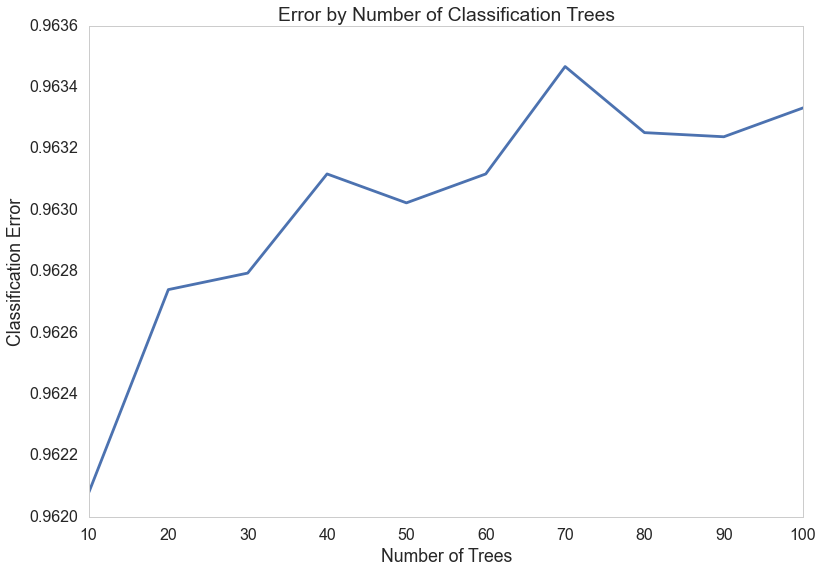

In [26]:
#show plot of error and number of trees in classifier
plt.plot(scores)
plt.xticks(np.arange(10),num_trees)
plt.ylabel('Classification Error')
plt.xlabel('Number of Trees')
plt.title('Error by Number of Classification Trees')
plt.grid('off')
plt.show()

Here is where I see where the optimal number of trees to be built is. So, the more trees you build the better the prediction will be in theory, but if you build 100,000 trees a lot of them will be redundent and it will take FOREVER to train and test. Therefore, this graph shows that after about 20 trees the model's prediction power levels off. We end up using more trees just to be safe and end up using 70 in the next block of code below. This seems to be a good number to optimize the predictive power while not taking forever to create.

In [27]:
#check the score on the test set for overfitting
rf2 = RandomForestClassifier(n_estimators = 70,
                             class_weight = rf2params['class_weight'], 
                             max_depth = rf2params['max_depth'],
                             max_features = rf2params['max_features'],
                             oob_score = True)

rf2.fit(X,Y)
print "Mean Accuracy of subsample prediction on test Set %0.1f" % (100*rf2.score(X_test,Y_test))
print "Mean Accuracy of subsample prediction on training Set %0.1f" % (100* rf2.score(X,Y))

Mean Accuracy of subsample prediction on test Set 96.3
Mean Accuracy of subsample prediction on training Set 98.3


Here we fit the model and look at the accuracy of the prediction on the training and test sets to test for overfitting. As you can see, there is a small drop in accuracy from training to test set (expected), but the difference is not large enough to worry about overfitting. Also, per the RandomForestClassifier documentation, the accuracy metric for multi-class prediction is particularly harsh because **each class is predicted for each observation and factored into the score**. Therefore, the accuracy reported here may under estimate accuracy on the different data sets.

In [28]:
from sklearn.externals import joblib
import os
os.chdir("modelfiles")
joblib.dump(rf2,"RandomForestClassifier.pkl", compress = 3)
os.chdir("..")
print os.getcwd()

C:\Users\ptrab_000\Uber-Data-Project


In [29]:
os.chdir("xcolumns")
joblib.dump(fcolumns,"columns.pkl", compress = 3)
clf = joblib.load('columns.pkl')
os.chdir("..")


This is code in order to save the model files for later use. This will later be used to impliment the model into the website.

#### Logistic Regression (Not used, just included for reference)

Here we just include the code used to test logistic regression. With logistic regression, we spent a lot of time trying to tune the predictor, but the model seemed to perform very similiar to the Random Forest. This makes intuitive sense for this dataset. The decision boundaries are much more complex in the Random Forest Classifier and are not strictly linear like that of the Logistic Regression. As the Exploratory analysis shows above, the factors do not seem to be very linear with respect to our classifications. Therefore, the logistic regression (even using both Lasso and Ridge regularization) was not used in favor of the Random Forest Classifier.

In [30]:
# Fix the Y variable for Logistic Regression
df_final['surge'].head()
Y_lreg = df_final['surge'][mask]
Y_lregtest = df_final['surge'][~mask]
Y_lreg.head()

0    No Surge
1    No Surge
3    No Surge
4    No Surge
5    No Surge
Name: surge, dtype: object

In [31]:
#parameters to be tested for Logistic Regression
lreg_paramdict = {}
lreg_paramdict['C'] = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lreg_paramdict['penalty'] = ['l1','l2']
lreg_paramdict['multi_class'] = ['ovr']
lreg_paramdict['class_weight'] = ['auto',None]
lreg = LogisticRegression(solver ='lbfgs' )

Above are the hyperparameters that are passed into the regression crossvalidation function. C stands for the regularization coefficient to effect the magnitude of the penalty of having excess variables. Penalty provides the regularization penalty. The 'l1' input uses the Lasso regression model to heavily restrict the feature selection, while 'l2'(Ridge) also restricts feature selection but less. We also altered the solver used and how the algorithm accounts for the multiple classes, but neather seemed to affect the prediction to a great extent.

In [32]:
%%time
#optimize parameters for logistic regression
lreg2, lregparams = cv_optimize(lreg,lreg_paramdict, X, Y_lreg)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)
Wall time: 36min 41s


In [33]:
lreg2 = LogisticRegression(solver ='lbfgs', C = lregparams['C'], class_weight = lregparams['class_weight'],
                           multi_class = lregparams['multi_class'], penalty = lregparams['penalty'] )
lreg2.fit(X,Y_lreg)
print "Mean Accuracy of prediction on test Set %0.1f" % (100*lreg2.score(X_test,Y_lregtest))
print "Mean Accuracy of prediction on training Set %0.1f" % (100* lreg2.score(X,Y_lreg))

Mean Accuracy of prediction on test Set 96.4
Mean Accuracy of prediction on training Set 96.4


As you can see, there is not any indication of overfitting using this model. However, the accuracy seems to be very similiarto the Random Forest Prediction as discussed above. Therefore, no additional work was done using logistic regression.

##Final Analysis

The final analysis, as discussed above, was completed using the Random Forest Classifier due to our preference to work with sklearn's implimentation of the Random Forest. First, we look at the feature importance found in the model sorted by the features that effect the prediction the most. Second, we restrict the model to the Boston area to look at how the city specific surge prices are affected by some of the most important variables found in the model: temperature and cartype.

###Feauture Importance

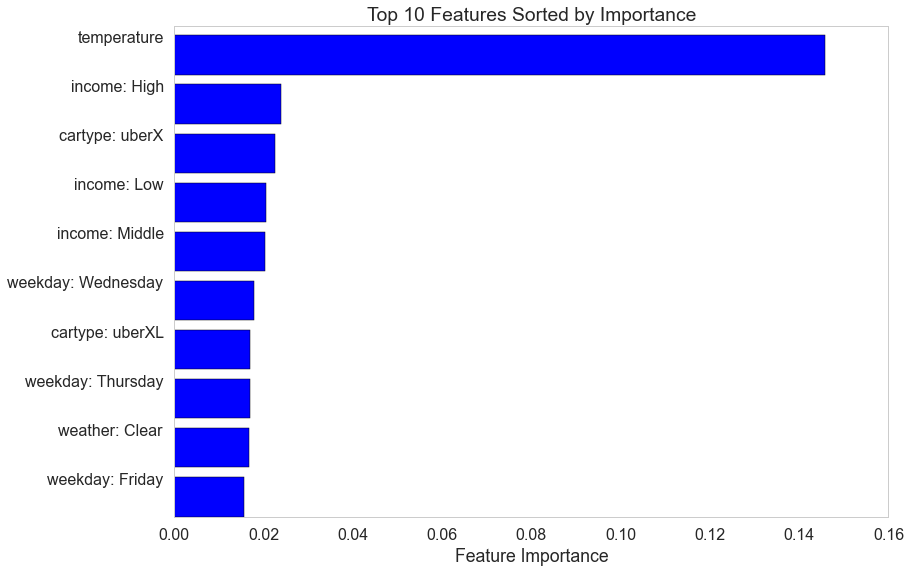

In [159]:
features = rf2.feature_importances_

feature_dict = {}
for i in range(len(features)):
    feature_dict[fcolumns[i]] = features[i]

keys_sorted = sorted(feature_dict, key=feature_dict.get, reverse=True)[:10]

feature_list = []
feature_name = []
for i in range(len(keys_sorted)):
    feature_list.append(feature_dict[keys_sorted[len(keys_sorted)-1-i]])
    temp = keys_sorted[len(keys_sorted)-1-i]
    temp = temp.replace("=", ": ")
    feature_name.append(temp)


plt.barh(np.arange(10),feature_list, color = 'blue')
plt.yticks(np.arange(10) + 0.75, feature_name)
plt.grid('off')
plt.title('Top 10 Features Sorted by Importance')
plt.xlabel('Feature Importance')
    

The above graph shows the top 10 most predictive features in the model. As you can see (fairly surprisingly), temperature is by far the most predictive variable that we pass into the model. Second, the next variable that seems to effect the prediction is the type of car. This is interesting because our car type feature serves as a proxy for the supply and demand dynamics of each uber service. The effect of the different car types and temperature is further explored below

###Feature Effect on Boston Ubers

####Temperature

In [162]:
test = range(30,71)
temp_X = [0] * len(fcolumns)

# Set cartype to uberX
temp_X[4] = 1
#Set city to Boston
temp_X[7] = 1
#Set income to Middle
temp_X[13] = 1
#Set time to 17:30
temp_X[66] = 1
#Set weather to Clear
temp_X[len(temp_X) - 11] = 1
#Set Day to wednesday
temp_X[len(temp_X)-1] = 1

# get prediction probabilities
prob_nsurge = []
for i in test:
    temp_X[14] = i
    prob_nsurge.append(rf2.predict_proba(temp_X)[3][0][0])

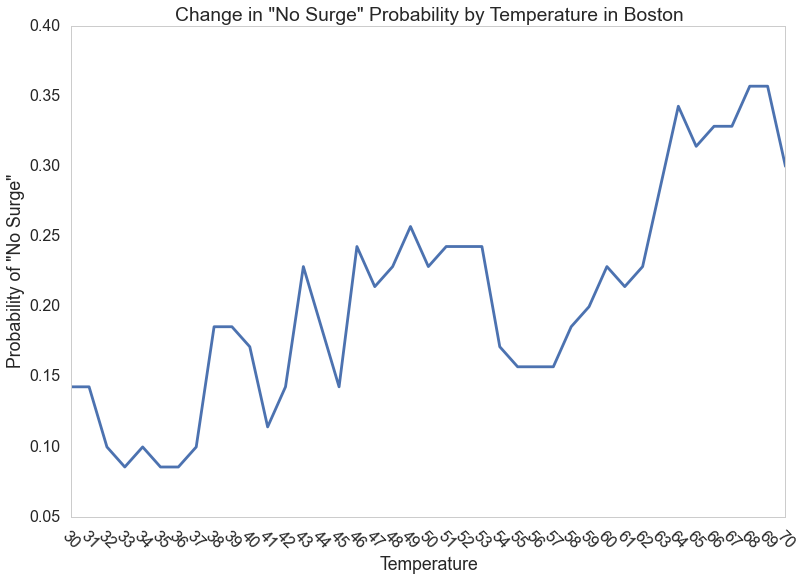

In [168]:
plt.plot(prob_nsurge)
plt.xticks(np.arange(len(test)),test, rotation = -45)
plt.grid('off')
plt.ylabel('Probability of "No Surge"')
plt.xlabel('Temperature')
plt.title('Change in "No Surge" Probability by Temperature in Boston')
plt.show()

This is one of the main outputs of our model. As temperature increases so does the probability of their being no uber surge. Interestingly enough, if you want to get a cheap uber, then use the service when it is hot outside! It appears that the colder the temperature is, the more likely there is to be a surge multiple on your uber ride in Boston.

####Time

In [145]:
test = range(6)
temp_X = [0] * len(fcolumns)

# Set cartype to uberX
temp_X[14] = 50
#Set city to Boston
temp_X[7] = 1
#Set income to Middle
temp_X[13] = 1
#Set time to 17:30
temp_X[66] = 1
#Set weather to Clear
temp_X[len(temp_X) - 11] = 1
#Set Day to wednesday
temp_X[len(temp_X)-1] = 1

# get prediction probabilities
prob_nsurge = []
for i in test:
    temp_X[i] = 1
    prob_nsurge.append(rf2.predict_proba(temp_X)[3][0][0])

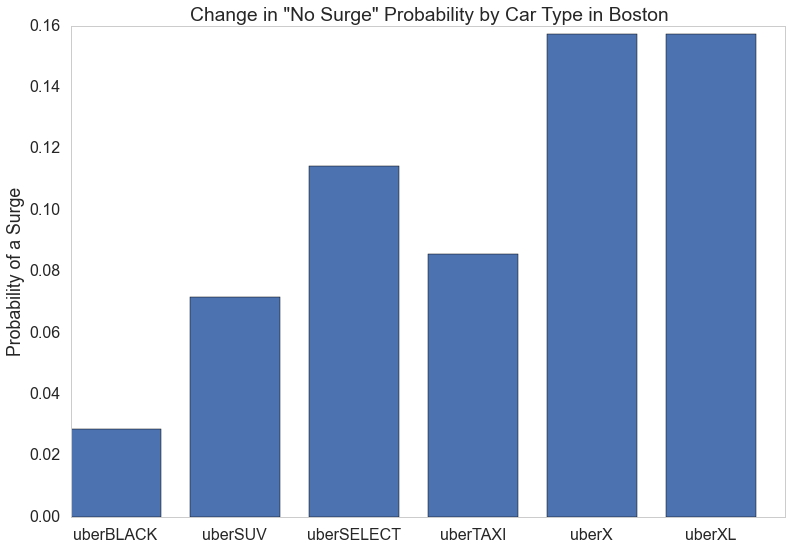

In [160]:
bar_width = 0.75
plt.bar(np.arange(len(test)),prob_nsurge, bar_width)
plt.xticks(np.arange(len(test))+bar_width/2, ('uberBLACK', 'uberSUV', 'uberSELECT', 'uberTAXI', 'uberX','uberXL'))
plt.ylabel('Probability of a Surge')
plt.grid('off')
plt.title('Change in "No Surge" Probability by Car Type in Boston')
plt.show()

The graph above shows an interesting proxy into customer usage of uber's services in Boston. We interpret the graph as the higher the probability on the y axis, the more demand there is for that particular service, which in turn leads to higher surges. Using the predifined variables inputed above, we see that uberX and uberXL are by far the most demanded services in the Boston area. uberBlack seems to be the least demanded service. We find this very interesting because it shows that we are able to use the model to show usage behaivor of each uber service. The graph also shows the widespread application of the model that we created and the incredible amount of analysis that can be done to glean insites into uber's business!

##Final Comments


In conclusion, we were constantly annoyed when calling for an uber and being charged extra for the inevitable surge pricing. We wanted to create a model that was able to give us predictive power on whether it was a good idea to call the uber now, or maybe use a different service that is more cost effective at that particular point in time. First, we collected the data using uber's new API on an AWS machine. Second, we used exploratory data analysis to glean more insights into the data set. Much of the exploratory data analysis proved our intuition correct. For example, the colder the temperature, the less likely people are to walk and the more likely there will be a surge price on ubers. Finally, we trained a Random Forest Classifier on our dataset to have a comprehensive model that can be used to glean further insights into the data and create a very reliable prediction of the surge price (over 96% accuracy!). After creating the model, we wanted to look at Boston specifically. We turned attention to two of the most important features we found in our model: temperature and car type. We proved our intuition with temperature using the model, then showed that it is possible also show consumer behaivor in Boston with respect to service type. 

**We appear to have a prediction on uber surge pricing!**


##Further Research

Although we have completed a lot of analysis in this project, we realize that there are many more possibilites and analysis that can be done on this data set. We could extend the data collection to more cities or increase the feature selection. We could use the model for more creative ways with expanding input features. Really, the scope of the project can be extended to almost all personal data that can be collected. We see the endless possibilites, and this project really only scratched the surface.